In [35]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns





In [160]:
!pip3 install --user --upgrade -e git+https://github.com/twintproject/twint.git@origin/master#egg=twint

Obtaining twint from git+https://github.com/twintproject/twint.git@origin/master#egg=twint
  Updating ./src/twint clone (to revision origin/master)
  Running command git fetch -q --tags
  Running command git reset --hard -q origin/master
  Attempting uninstall: twint
    Found existing installation: twint 2.1.21
    Uninstalling twint-2.1.21:
      Successfully uninstalled twint-2.1.21
  Running setup.py develop for twint


In [1]:
import twint
import nest_asyncio
nest_asyncio.apply()
#we need nest_asyncio to call async routines,similar as performing concurrent tasks.

In [13]:
#configuration
config = twint.Config()
config.Search = "covid crisis india"
config.Limit = 10
#running search
config.Hide_output = True
config.Pandas = True
twint.run.Search(config)
df = twint.storage.panda.Tweets_df #result is saved to df


In [17]:
df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'timezone', 'place',
       'tweet', 'language', 'hashtags', 'cashtags', 'user_id', 'user_id_str',
       'username', 'name', 'day', 'hour', 'link', 'urls', 'photos', 'video',
       'thumbnail', 'retweet', 'nlikes', 'nreplies', 'nretweets', 'quote_url',
       'search', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

In [20]:
#extract year,month,day into new columns from datetime column
df['year']=pd.to_datetime(df['date']).dt.strftime('%Y')
df['month']=pd.to_datetime(df['date']).dt.strftime('%m')
df['day']=pd.to_datetime(df['date']).dt.strftime('%A')

In [24]:
def preprocess_tweets(tweet):
    
    fo = open("stopwords.txt", "r+")
    stop_words = list(fo.read().split(','))
    translation={39:None}
    processed_tweet = tweet
    processed_tweet=' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",tweet).split())
    processed_tweet = " ".join(word for word in processed_tweet.split() if word not in str(stop_words).translate(translation))
    return(processed_tweet)
df['Processed Tweet'] = df['tweet'].apply(lambda x: preprocess_tweets(x.lower()))

In [25]:
#here we are making a new column 'polarity' by applying textblob function on the processed tweets which are in english language
from textblob import TextBlob
df['polarity'] = df[df['language']=='en']['Processed Tweet'].apply(lambda x: TextBlob(x).sentiment[0])


In [27]:
df['sentiment'] = df['polarity'].apply(lambda x: 'positive' if x > 0 else('negative' if x<0  else 'neutral'))


In [28]:
print(df)

                     id      conversation_id  ...  polarity sentiment
0   1460354658493472770  1460287960377540609  ... -0.136364  negative
1   1460293368471298062  1460257213105250307  ...  0.000000   neutral
2   1460291892424232960  1460291892424232960  ...  0.000000   neutral
3   1460291152993603590  1460282062435340295  ...  0.000000   neutral
4   1460248471034810376  1460248471034810376  ...  0.600000  positive
5   1460196467335905288  1460196467335905288  ...  0.233333  positive
6   1460183118195929094  1460183118195929094  ...  0.000000   neutral
7   1460126250685579264  1460126250685579264  ...  0.000000   neutral
8   1460117158558670850  1460116897622634497  ...  0.000000   neutral
9   1459962798524575760  1459941955257962500  ... -0.300000  negative
10  1459940273967046657  1459940273967046657  ...  0.000000   neutral
11  1459884209925812228  1459884209925812228  ...  0.137500  positive
12  1459566732603920391  1459566732603920391  ... -0.100000  negative
13  1459553039136612

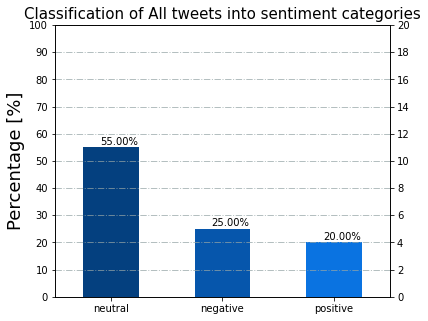

In [33]:
plt.figure(figsize=(6,5))
plt.title('Classification of All tweets into sentiment categories',fontsize=15)
plt.ylabel('Percentage [%]',fontsize=18)
ax = (df.sentiment.value_counts()/len(df)*100).plot(kind="bar", rot=0,color=['#04407F','#0656AC','#0A73E1'])
ax.set_yticks(np.arange(0, 110, 10))
plt.grid(color='#95a5a6', linestyle='-.', linewidth=1, axis='y', alpha=0.7)
ax2 = ax.twinx()
ax2.set_yticks(np.arange(0, 110, 10)*len(df)/100)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

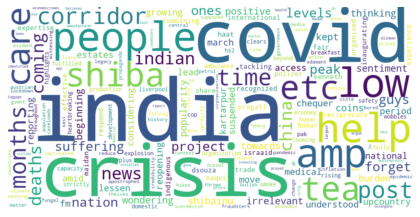

In [39]:
from wordcloud import WordCloud,ImageColorGenerator
text = " ".join(tweet for tweet in df['Processed Tweet'].astype(str))
wordcloud = WordCloud(
    background_color = 'white',
    width = 1000,
    height = 500).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.rcParams['figure.figsize'] = [20, 20]
plt.tight_layout()
